<a href="https://colab.research.google.com/github/KishorAlagappan/Fraudulent-transactions-Detection-ML-model/blob/main/Fraudulent_transactions_Detection_ML_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Probelm Statement / Business Context**

---


This case requires trainees to develop a model for predicting fraudulent transactions for a 
financial company and use insights from the model to develop an actionable plan. Data for the 
case is available in CSV format having 6362620 rows and 10 columns.
Candidates can use whatever method they wish to develop their machine learning model. 
Following usual model development procedures, the model would be estimated on the 
calibration data and tested on the validation data. This case requires both statistical analysis and 
creativity/judgment. We recommend you spend time on both fine-tuning and interpreting the 
results of your machine learning model.

---



In [38]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [39]:
df = pd.read_csv('/content/drive/MyDrive/Fraud (1).csv')

df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# Data Fields

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


---



In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [41]:
# Checking if there are any null values in our dataset
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [42]:
#Dropping the Duplicate values in our dataset
df = df.drop_duplicates()   
df.shape 

(6362620, 11)

In [43]:
#Function for Visualization 
def show_distribution(dataframe, col):
    fig, ax = plt.subplots(1, 2, figsize=(20,8))
    sns.set_style('darkgrid')
    sns.boxplot(data=dataframe, x=col, ax=ax[0])
    ax[0].set_title(f'{col.title()} Boxplot')
    
    sns.histplot(data=dataframe, x=col, ax=ax[1], kde=True)
    ax[1].set_title(f'{col.title()} Histogram')
    
    fig.suptitle(f'{col.title()} Distribution'.replace('_', ' '), fontsize=15, color='brown')

In [44]:
object_cols = df.select_dtypes(include='object').columns
object_cols

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [45]:
for i in object_cols:
    print(f'Number of unique values in {i} : {df[i].nunique()}')
    print(f'Unique Value {i}\n:{df[i].unique()}\n')
    print(df[i].value_counts())
    print('----------------------------------------------')

Number of unique values in type : 5
Unique Value type
:['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
----------------------------------------------
Number of unique values in nameOrig : 6353307
Unique Value nameOrig
:['C1231006815' 'C1666544295' 'C1305486145' ... 'C1162922333' 'C1685995037'
 'C1280323807']

C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: nameOrig, Length: 6353307, dtype: int64
----------------------------------------------
Number of unique values in nameDest : 2722362
Unique Value nameDest
:['M1979787155' 'M2044282225' 'C553264065' ... 'C1850423904' 'C1881841831'
 'C2080388513']

C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470



1.  The types of online transaction which is most frequent is cash-out/cash-in/payment/Transfer
2. In 'nameDest & nameOrg' columns, we can replace the values which occure one time or more to (others) to make data more simple or drop these columns.



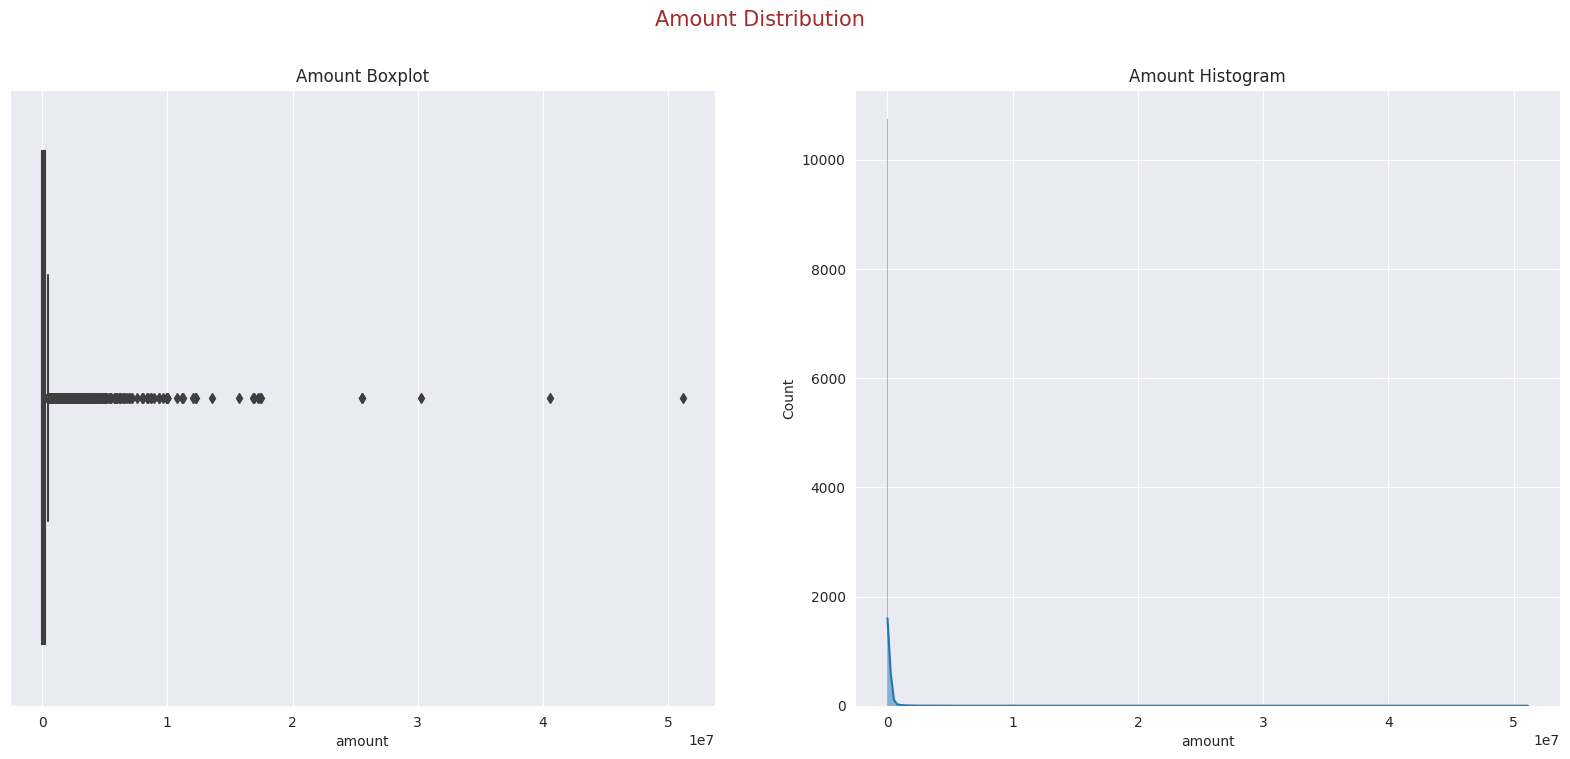

In [46]:
show_distribution(df.sample(50000),'amount')

In [47]:
number_cols = df.select_dtypes(exclude='object').columns
number_cols

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'isFlaggedFraud'],
      dtype='object')

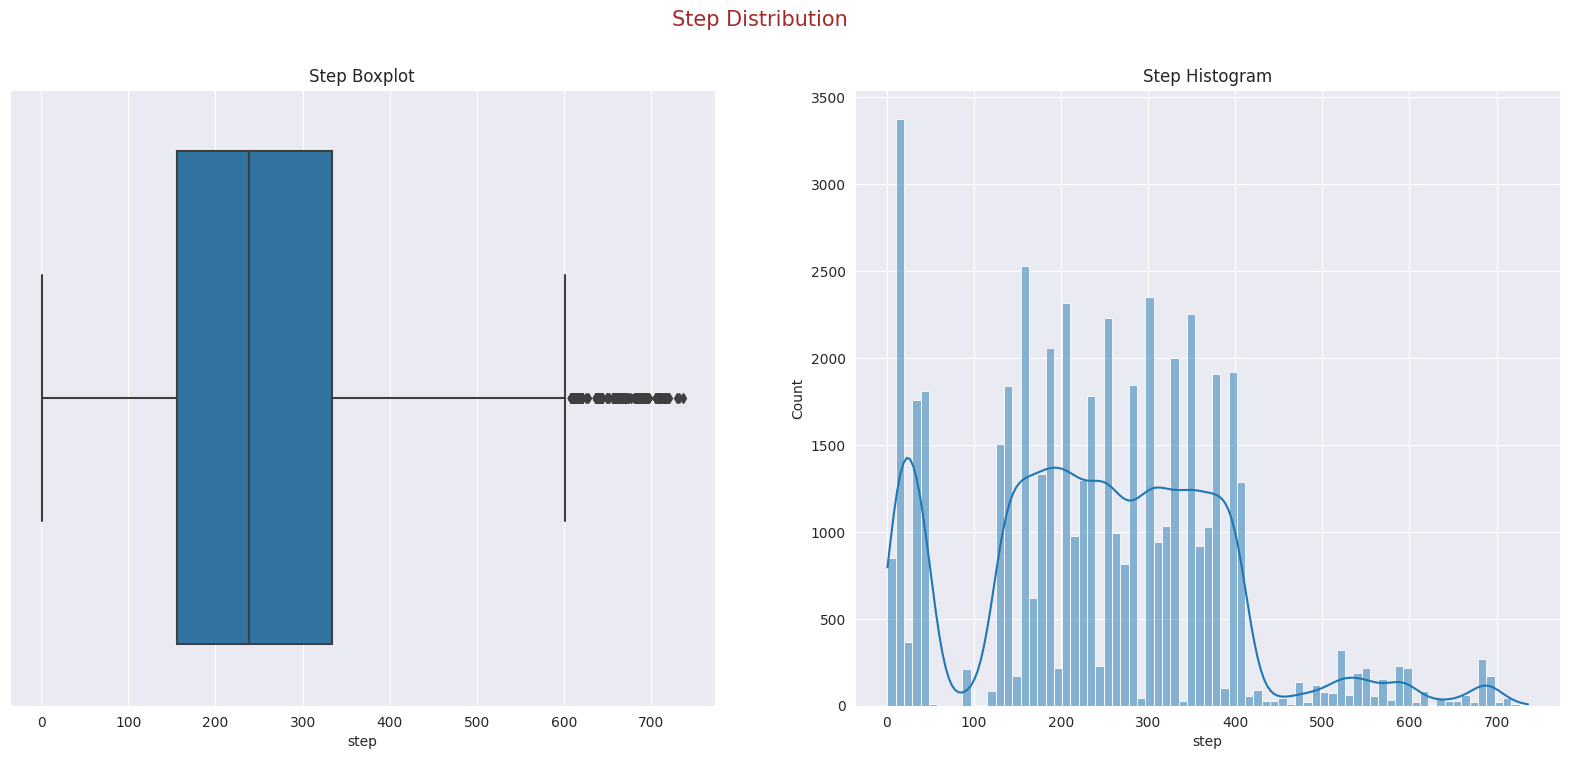

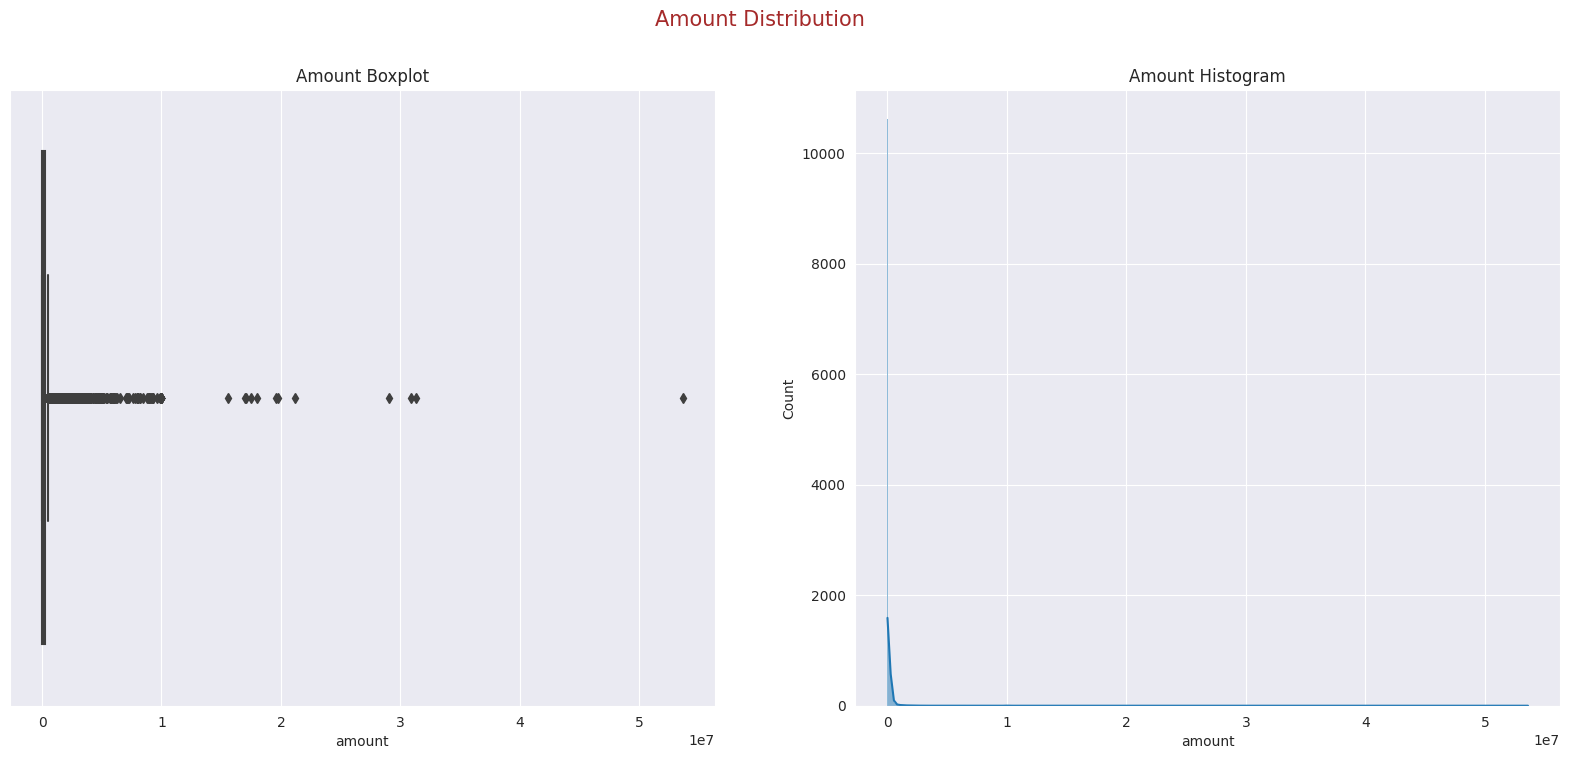

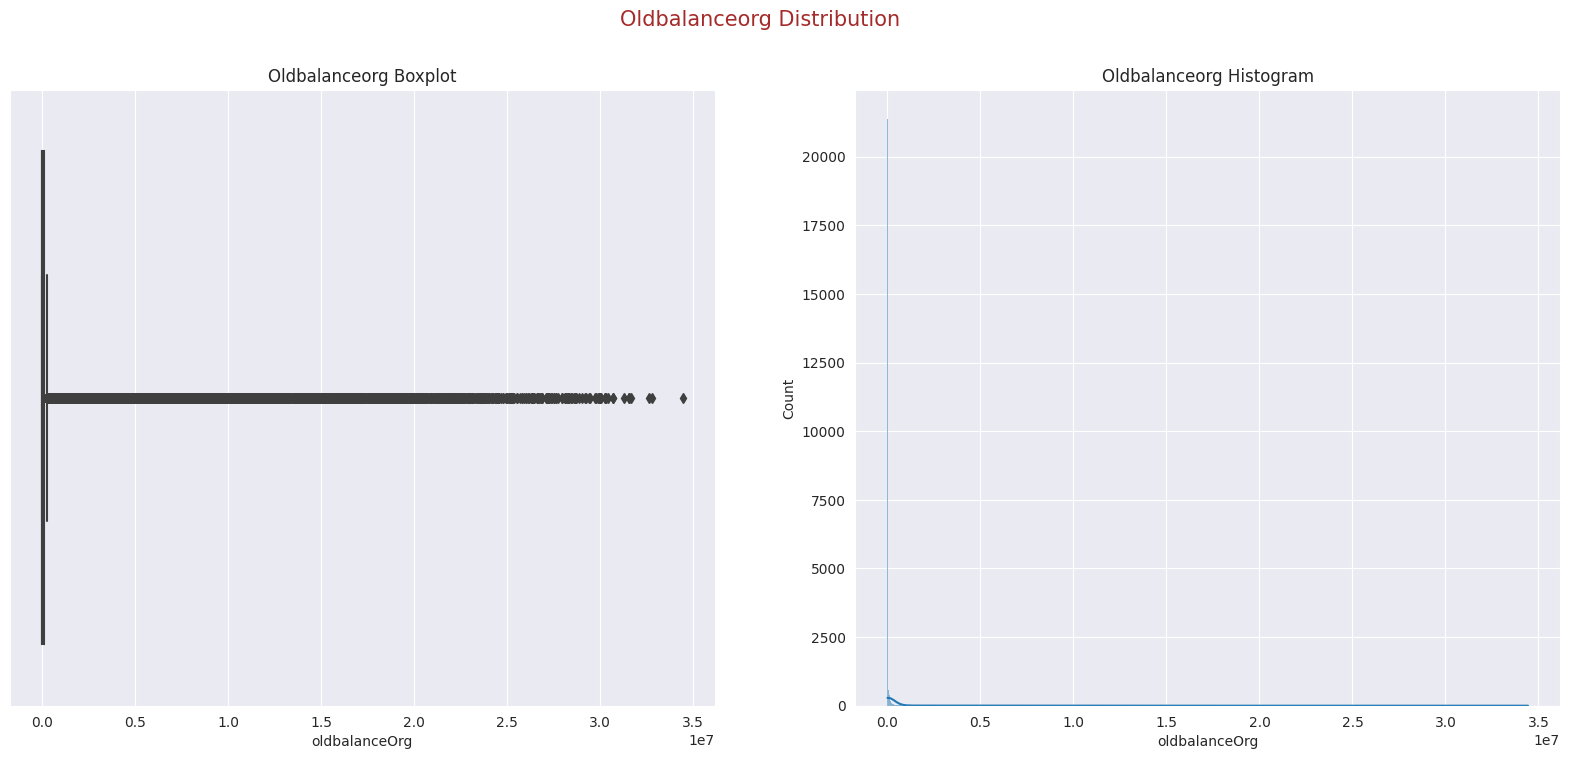

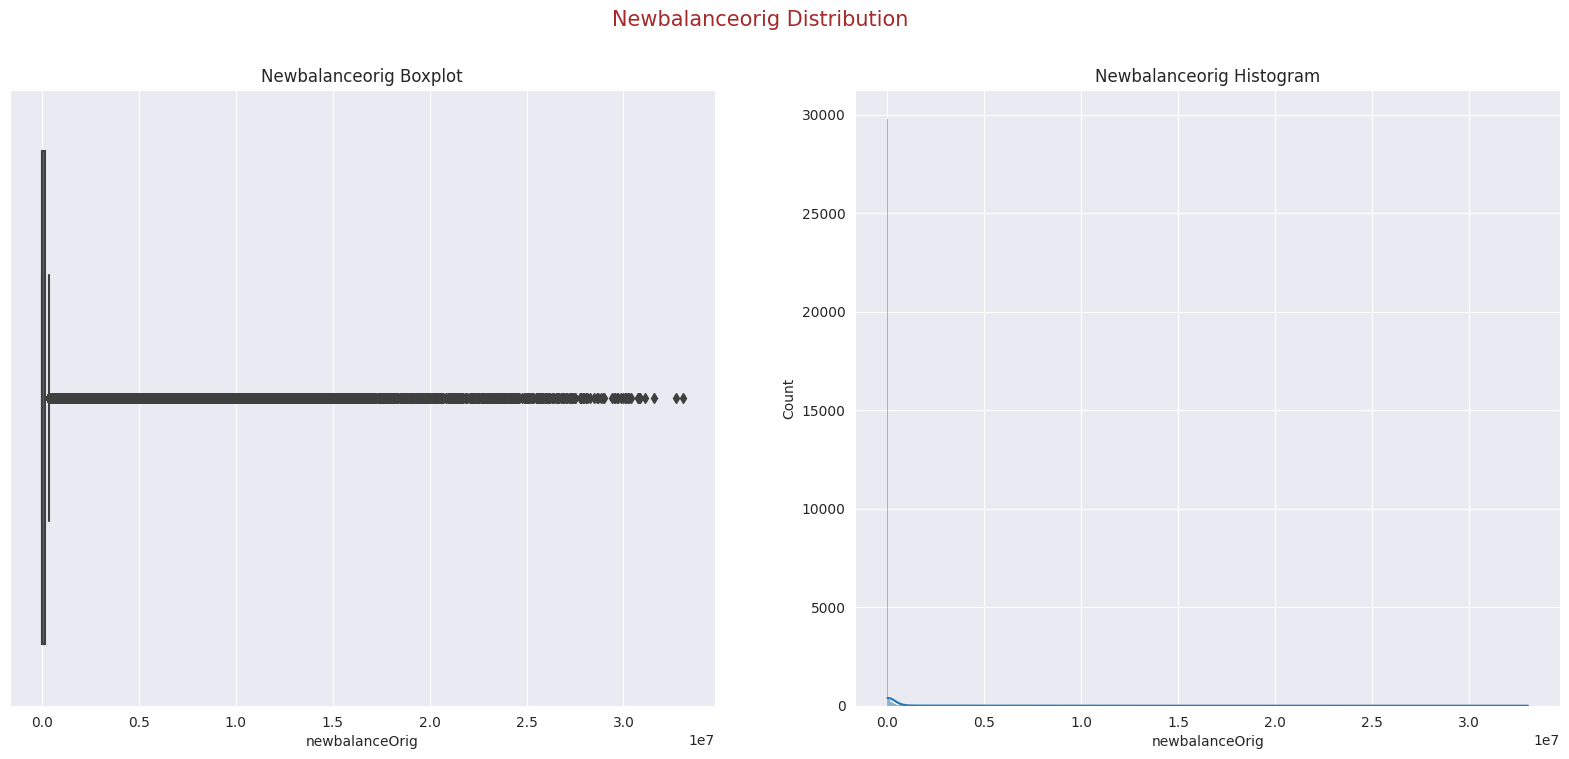

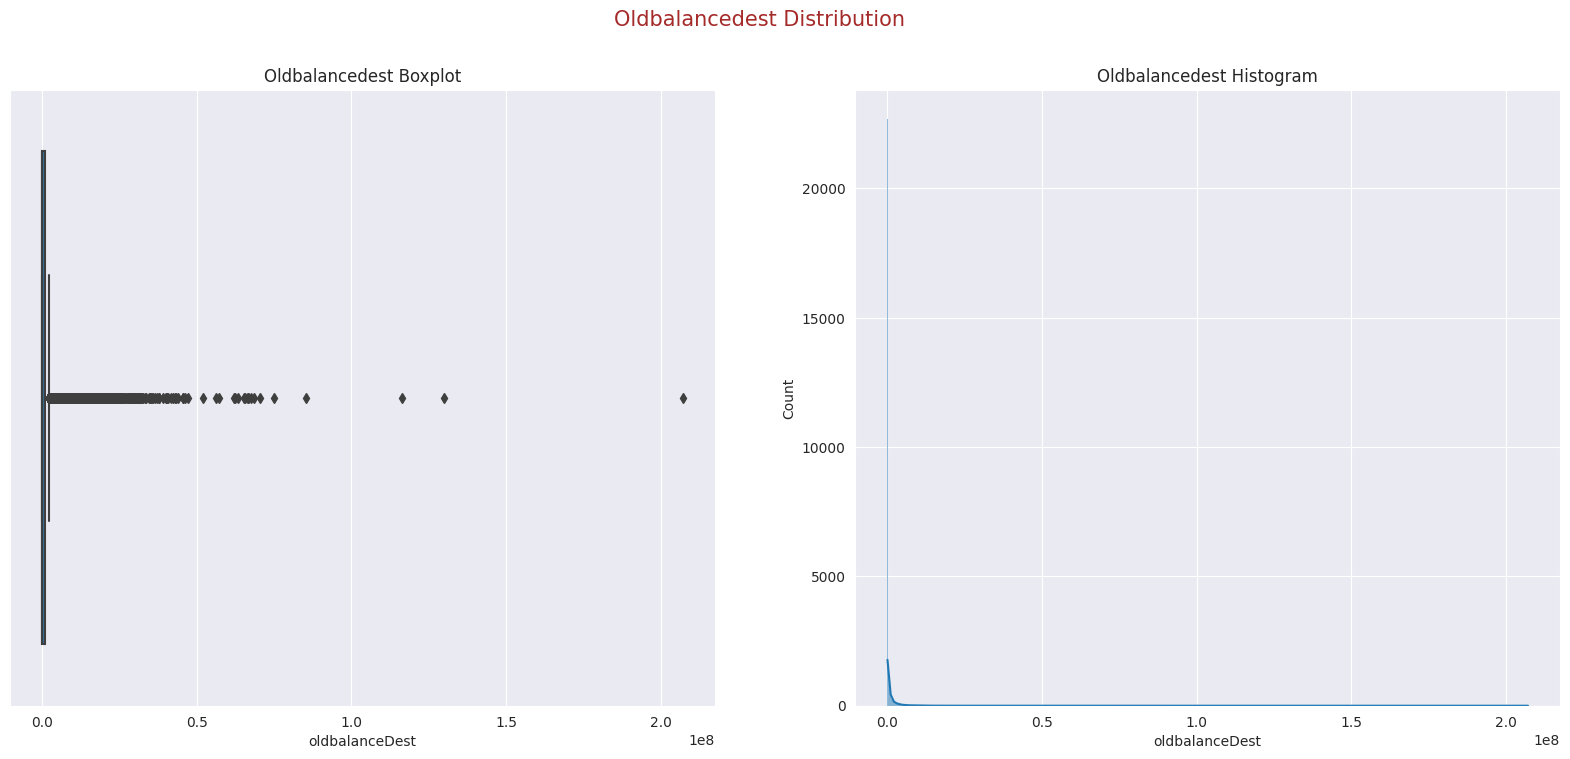

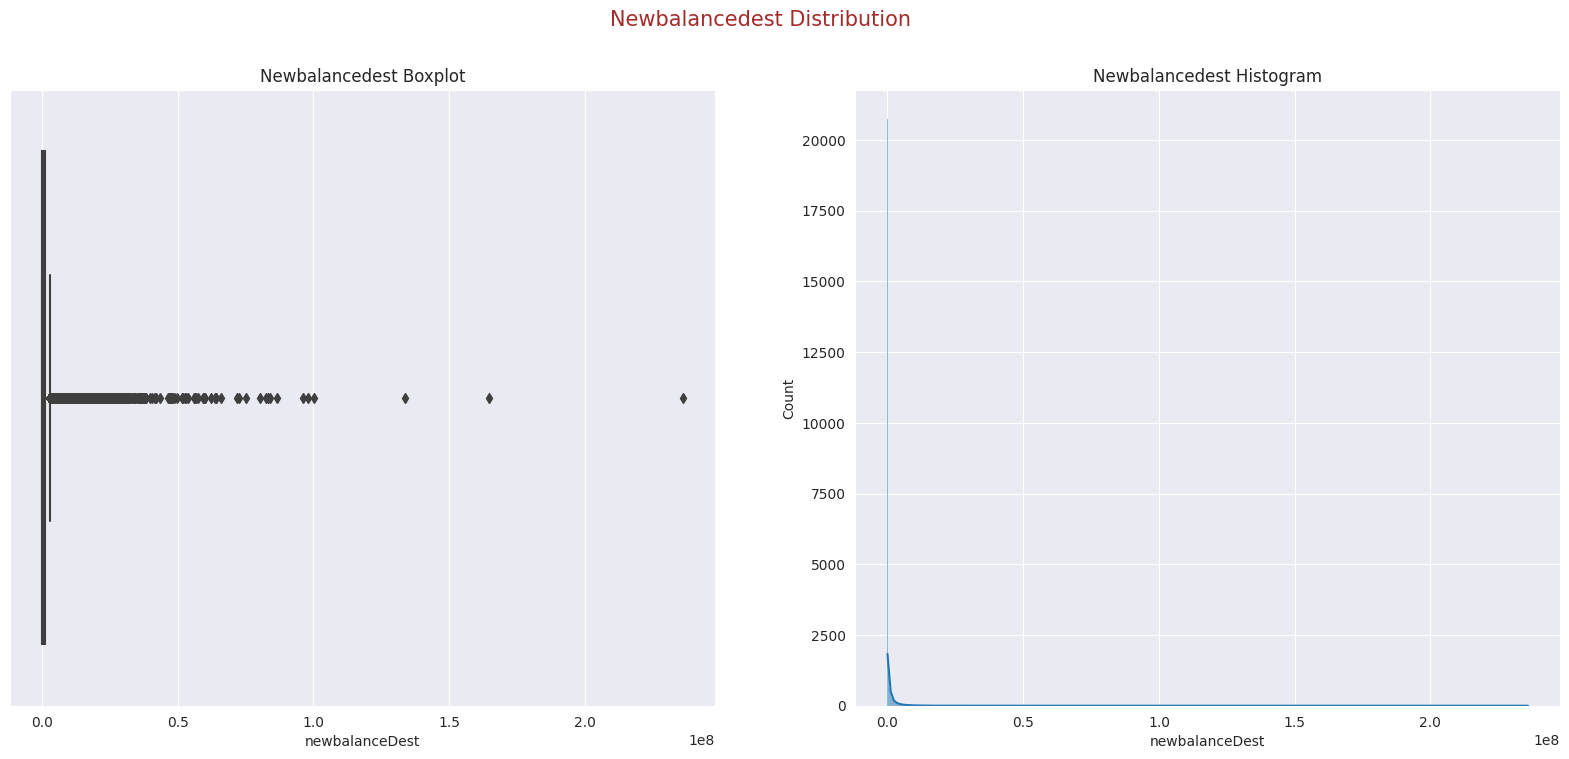

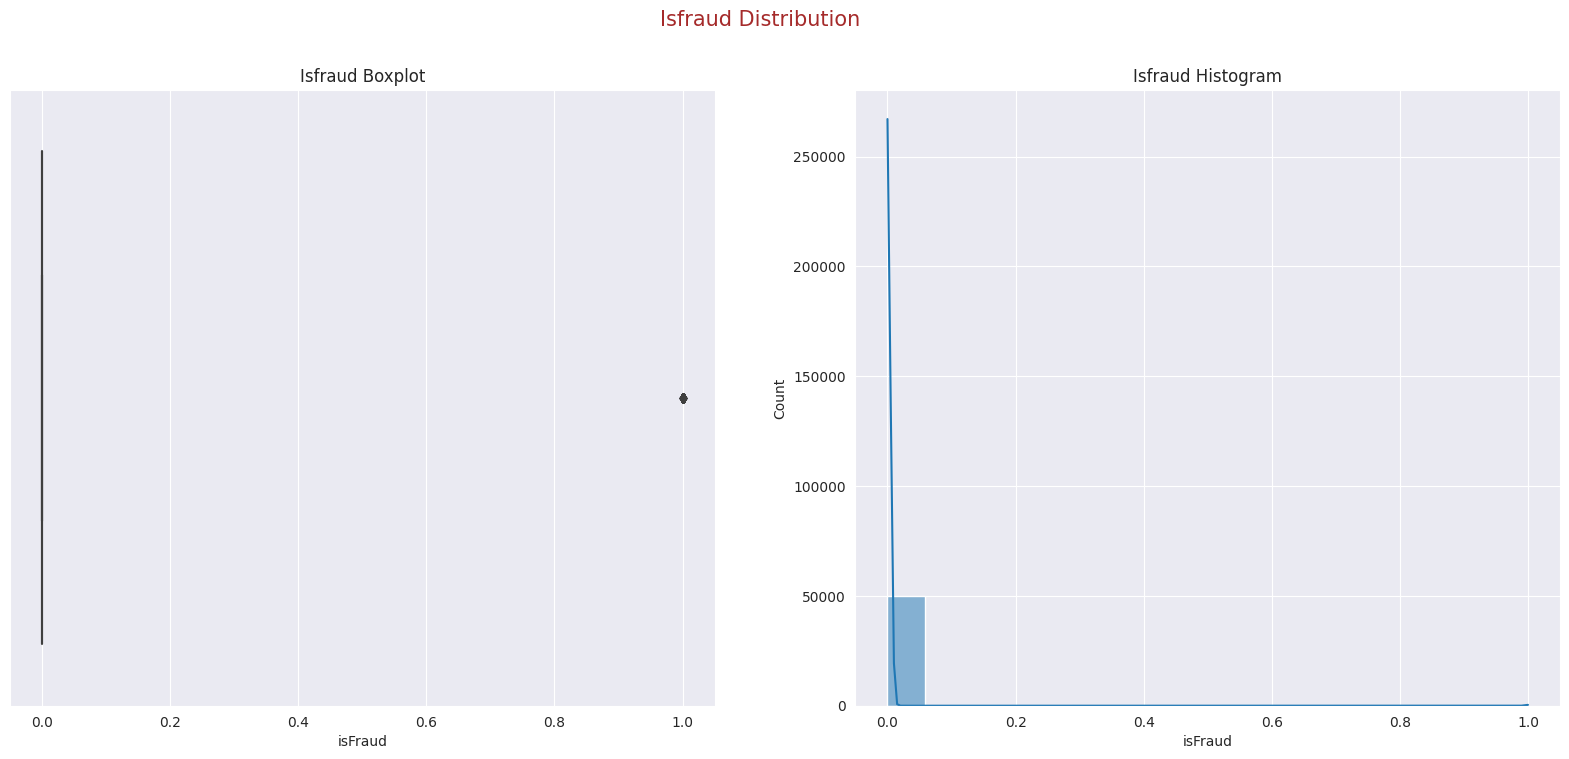

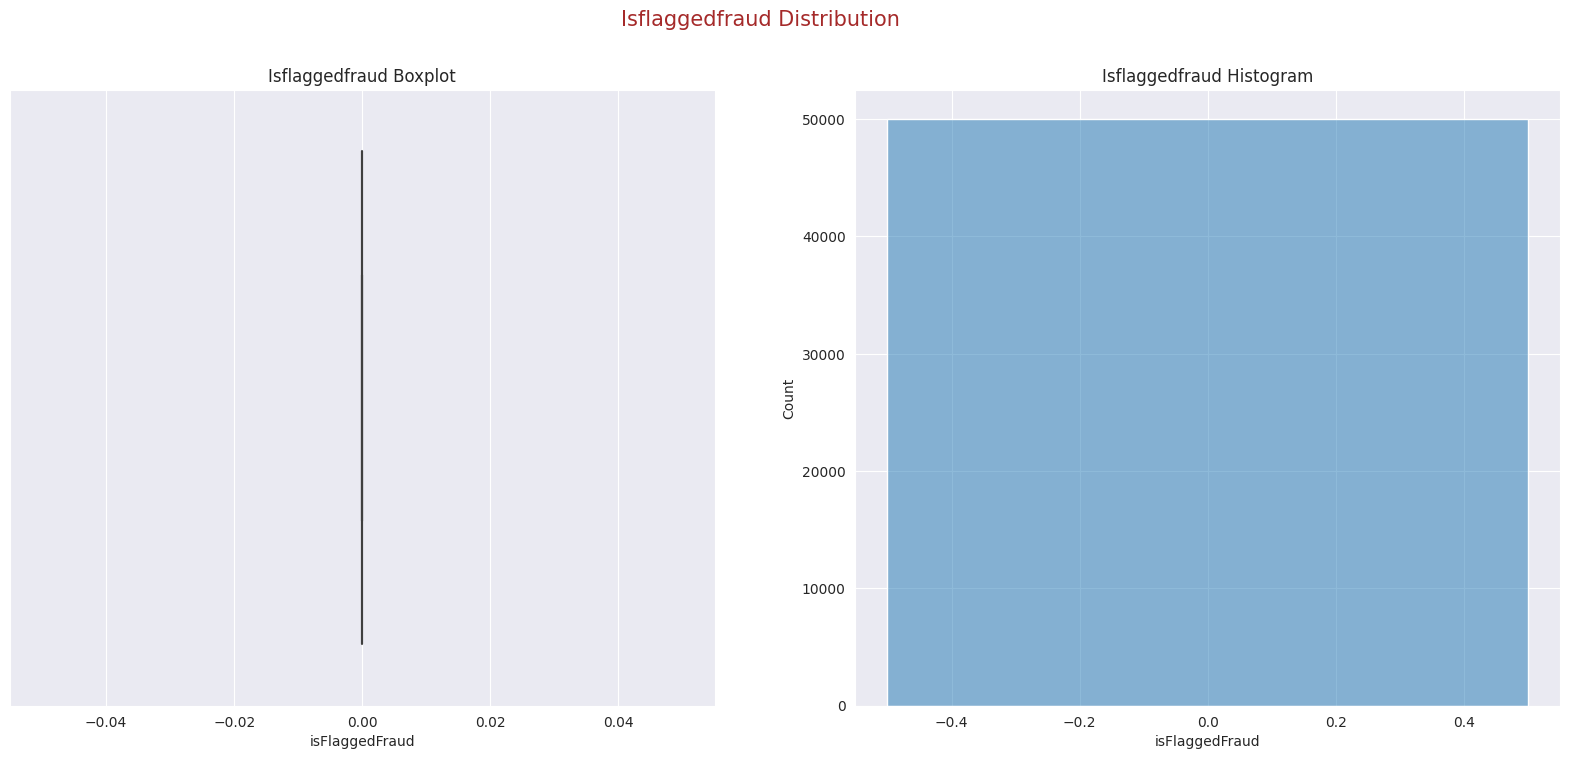

In [48]:
for i in number_cols:
    show_distribution(df.sample(50000), i)

We can observe that the data size is over 6 million records. when we take a sample from data and see the distribution, It's have the same distribution for the full data which is 6 million records. So I did the distribution from sample data.

In [49]:
# Checking isFlaggedFraud column
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [50]:
# Dropping columns that are not needed
df.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1,inplace=True)

In [51]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [52]:
# Let's look at the percentage of each category in isFraud column(target column)
print("No Frauds:",df['isFraud'].value_counts()[0]/len(df['isFraud'])*100)
print("Frauds:",df['isFraud'].value_counts()[1]/len(df['isFraud'])*100)

No Frauds: 99.87091795518198
Frauds: 0.12908204481801522


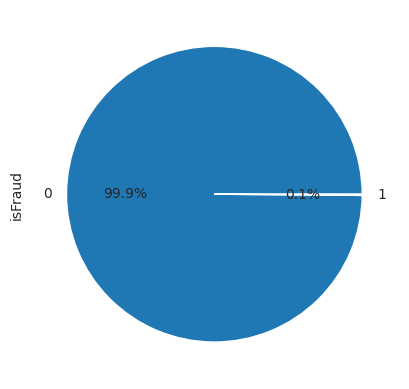

In [53]:
df['isFraud'].value_counts().plot.pie(autopct='%1.1f%%');